In [1]:
# Base modules

from numpy import load
import numpy as np
from pathlib import Path

# Import os & glob
import os
import glob

# Import plot tools
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from mpl_toolkits import mplot3d

# Import data analysis tools
from scipy.signal import savgol_filter
from scipy import interpolate
import pandas as pd
from scipy.signal import find_peaks

import seaborn as sns
import matplotlib.gridspec as grid_spec

from statsmodels.graphics import tsaplots
import random

# Import timing
import time
import natsort
import itertools

from sklearn.utils import shuffle

import plotly.express as px
from tqdm.notebook import tqdm

%matplotlib widget

In [2]:
desired_cols = ['fishz', 'fishy', 'fishx','realtime']
# read file
df = pd.read_csv("C:/PhD/long-term-free-swim/05_T1_67b4c062170111edae5c003053fc6914_VR03.csv.gz", usecols=desired_cols)
dfx= df

In [3]:
# #  get all files form folder with keyword 01
# path = "C:/PhD/17010223/long-term-free-swim/"
# all_files = glob.glob(os.path.join(path, "01*.csv.gz"))
# #  concatenate all files
# df = pd.concat((pd.read_csv(f, usecols=desired_cols) for f in all_files), ignore_index=True)
# dfx= dfx.append(df, ignore_index=True)

In [4]:
zs = dfx["fishx"].rolling(window=11, center=True).mean().interpolate(method="pad")
ys = dfx["fishy"].rolling(window=11, center=True).mean().interpolate(method="pad")
xs = dfx["fishz"].rolling(window=11, center=True).mean().interpolate(method="pad")
dx= xs.diff().interpolate(method='bfill')
dy= ys.diff().interpolate(method='bfill')
dz= zs.diff().interpolate(method='bfill')

dfx["dx"] = dx
dfx["dy"] = dy
dfx["dz"] = dz


ddf=dfx

In [5]:
ddfs = ddf.diff(periods=1, axis=0)

steps = np.sqrt(ddfs["fishx"]**2 + ddfs["fishy"]**2 + ddfs["fishz"]**2)
ddfs["steps"] = steps

In [6]:
print('dx, dy, dz and steps quantiles')
print(ddfs['fishx'].quantile(0.999))
print(ddfs['fishy'].quantile(0.999))
print(ddfs['fishz'].quantile(0.999))

dx, dy, dz and steps quantiles
0.0028285380319325397
0.002960906237343295
0.004326712678278471


In [7]:
max_stepsize = 0.02 #m : 1.5 body lengths between successive frames

#... see where it happens...
large_steps = ddfs['steps'] > max_stepsize
count_large_steps = np.count_nonzero(large_steps)

print('Number of steps above threshold:')
print(count_large_steps)

Number of steps above threshold:
210


In [8]:
w = 10 #frames (represents half the window for deletion)
selected_columns = ['fishz', 'fishy', 'fishx']

large_step_indices = large_steps[large_steps].index.values

print(large_step_indices)
w = 10

for i in range(0, count_large_steps):
    lsi = large_step_indices[i]
    ddf.loc[lsi-w:lsi+w, selected_columns] = np.nan

[  8193   8290   8442   8451   8573   8595   8597   8701  22515  24711
  24719  27444  28818  32469  36811  49591  49664  49674  54249  54413
  54566  82306 101777 130294 132380 138192 138429 140248 144042 144119
 144209 154276 166024 166162 173019 178899 183596 186082 191219 194058
 194108 225839 233814 233987 260019 260438 272963 273130 273577 273690
 295178 295243 298087 298397 298398 298400 309863 310015 310016 310017
 338607 344876 347260 350055 376709 376848 377193 418675 422565 422607
 425259 427089 427193 427194 427195 427196 427197 428769 429121 429672
 432102 432226 432423 434249 434684 436158 436199 436237 438048 438049
 438798 441841 442480 442481 442537 442538 442539 442570 442638 442673
 442674 442704 443323 443758 443759 443760 443788 443789 443794 443798
 443799 443800 443808 443812 443819 443828 443837 443844 443852 443854
 443855 443860 443862 443864 443871 443874 443877 443883 443891 443893
 444135 444346 444394 444846 446651 450041 456002 458333 458388 466288
 47264

In [9]:
# cartesian to polar coodinates
def cart2pol(x,y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return(rho, phi)

# cartesian to spherical coordinates
def cart2sph(x,y,z):
    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z, np.sqrt(x**2 + y**2))
    R = np.sqrt(x**2 + y**2 + z**2)
    return(azimuth, elevation, R)

In [10]:
selected_columns = ['fishz', 'fishy', 'fishx']
err = 0.001 # accepted error

# delete: z < - 0.09
ddf.loc[ddf['fishz'] < - (0.09 + err), selected_columns] = np.nan

# delete: z > 0
ddf.loc[ddf['fishz'] > 0 + err, selected_columns] = np.nan

In [11]:
zoffset = 0.11

# spherical coordinates calculation
azimuth, elevation, R = cart2sph(ddf['fishx'], ddf['fishy'], ddf['fishz'] - zoffset)

In [12]:
selected_columns = ['fishz', 'fishy', 'fishx']
err = 0.005 # accepted error

# delete: z < - 0.09
ddf.loc[ R > 0.2 + err, selected_columns] = np.nan

# delete: z > 0
ddf.loc[ R < 0.11 - err, selected_columns] = np.nan

In [13]:
# angle = np.arctan2(dfx['dy'], dfx['dx'])
# dfx['angle'] = angle

# angle_temp = np.arctan2(dfx["fishy"], dfx["fishx"])
# dfx['angle_temp'] = angle_temp

In [14]:
# speed = np.sqrt(dfx['dx']**2 + dfx['dy']**2 + dfx['dz']**2)
# dfx['speed'] = speed

# speed_temp = np.sqrt(dfx["fishx"]**2 + dfx["fishy"]**2 + dfx["fishz"]**2)
# dfx['speed_temp'] = speed_temp

In [15]:
angle_wrappeds = np.arctan2(dy,dx)

#angle unwrapped
last = 0
angles = []
for i in range(0, len(dx)):
    phi = np.arctan2(dy[i],dx[i])
    while phi < last-np.pi: phi += 2*np.pi
    while phi > last+np.pi: phi -= 2*np.pi
    last = phi
    angles.append(phi)

angles = np.array(angles)

In [16]:
fHz = 100
dt = 1/fHz
velocity = np.sqrt(dx**2 + dy**2 + dz**2)/dt



In [17]:
velocity2 = np.sqrt(dfx.fishx**2 + dfx.fishy**2 + dfx.fishz**2)/dt


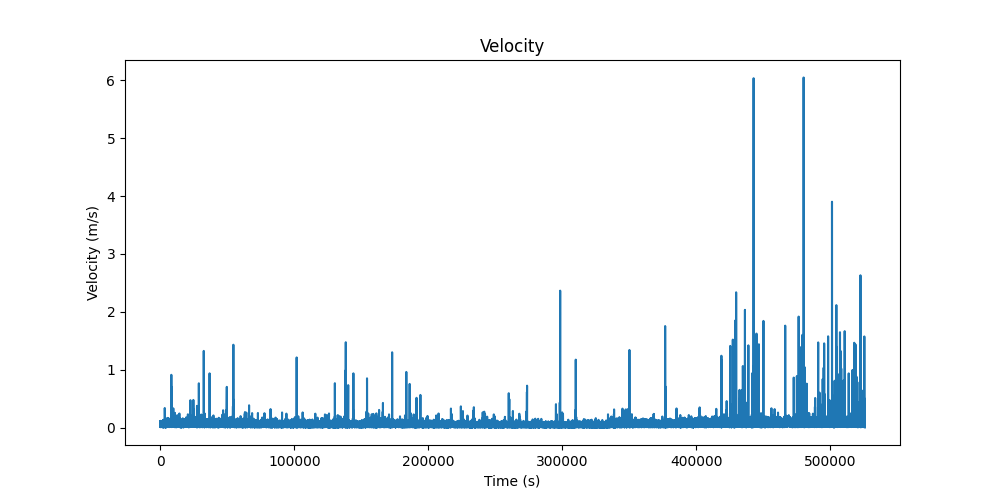

In [18]:
#  plot velocity

plt.figure(figsize=(10, 5))
plt.plot(velocity)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity')
plt.show()


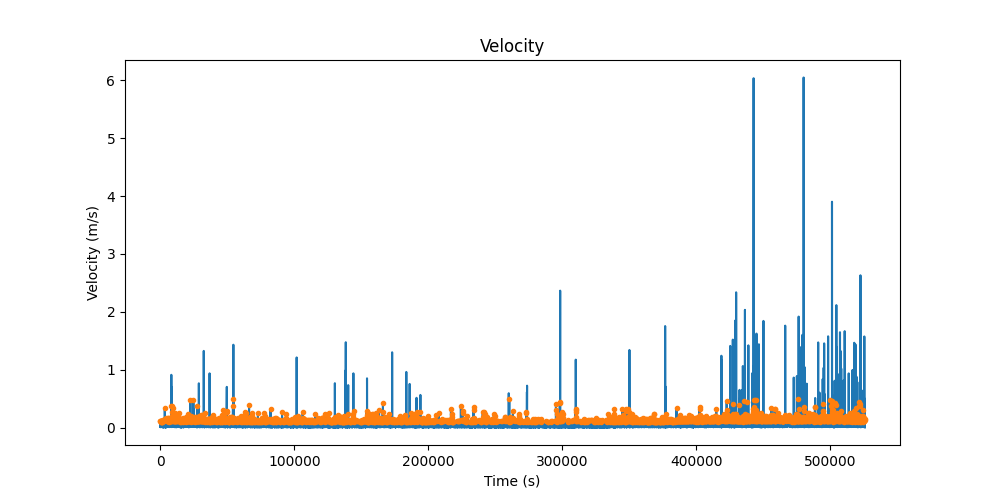

In [19]:
#  find peaks
height= (0.1, 0.5)
frames_btw_2bouts = round(fHz/5)
bout_width = round(fHz/100)
prominence = 0.08

peaks, _ = find_peaks(velocity, height=height, distance=frames_btw_2bouts, width=bout_width, prominence=prominence)

plt.figure(figsize=(10, 5))
plt.plot(velocity)
plt.plot(peaks, velocity[peaks], ".")
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity')
plt.show()


In [20]:
#  take angle at the peak
angles_at_peaks = angles[peaks]

# Normalize angles between -π and π
angles_at_peaks_normalized = np.mod(angles_at_peaks, 2 * np.pi) - np.pi

# Unwrap normalized angles
angles_at_peaks_unwrapped = np.unwrap(angles_at_peaks_normalized)

# Calculate differences between consecutive unwrapped angles
angles_at_peaks_diff = np.diff(angles_at_peaks_unwrapped)

# Apply modulo arithmetic to ensure range between -π and π
angles_at_peaks_diff = np.mod(angles_at_peaks_diff + np.pi, 2 * np.pi) - np.pi



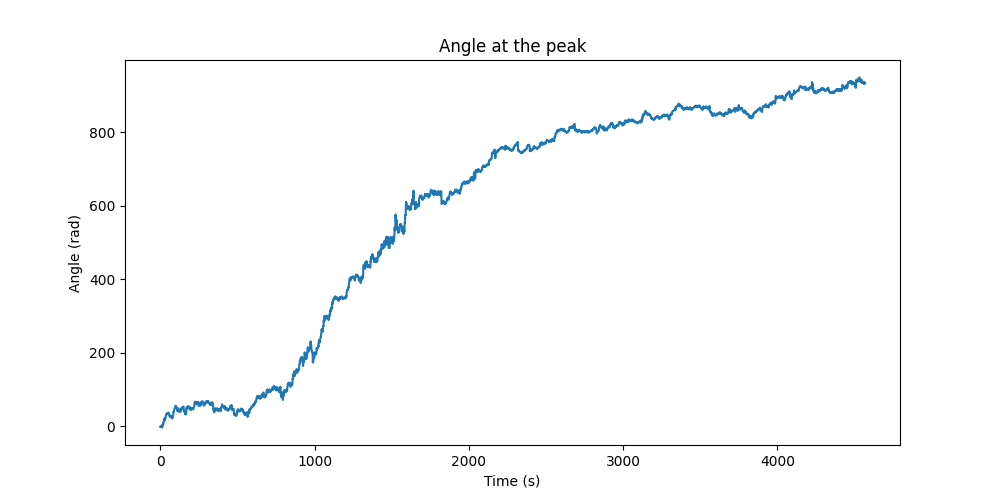

In [21]:
#  plot angle at the peak
plt.figure(figsize=(10, 5))
plt.plot(angles_at_peaks)
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Angle at the peak')
plt.show()

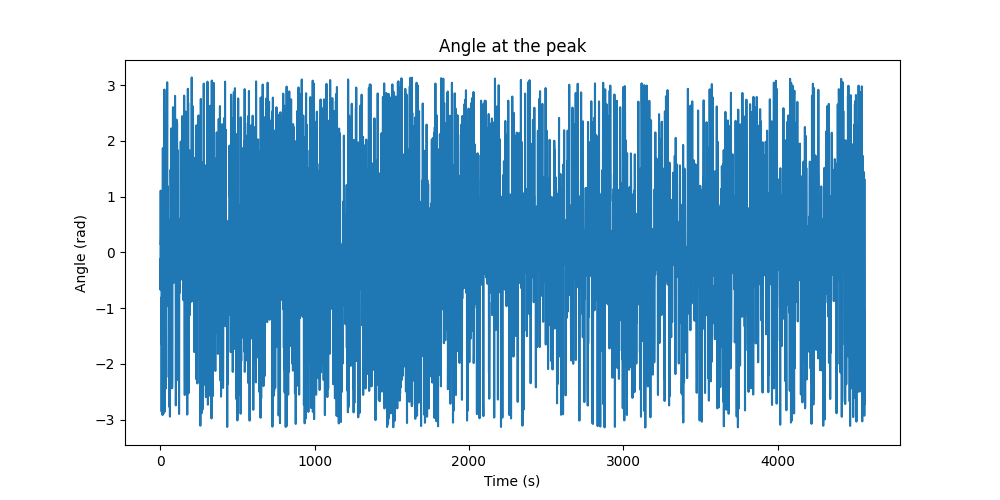

In [22]:

# make it in arn

#  plot the difference between two consecutive angles
plt.figure(figsize=(10, 5))
plt.plot(angles_at_peaks_diff)
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Angle at the peak')
plt.show()
    

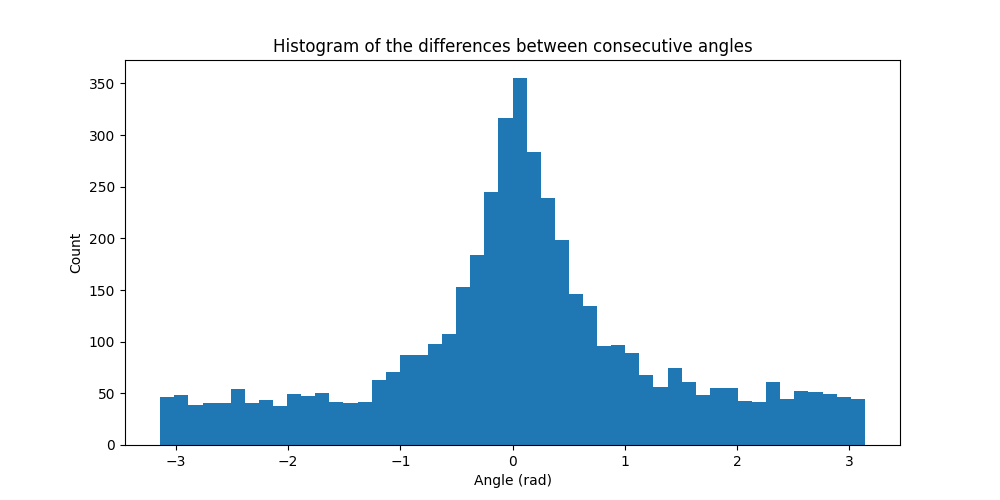

In [23]:
#  Draw a histogram of the differences between consecutive angles
plt.figure(figsize=(10, 5))
plt.hist(angles_at_peaks_diff, bins=50)
plt.xlabel('Angle (rad)')
plt.ylabel('Count')
plt.title('Histogram of the differences between consecutive angles')
plt.show()


In [24]:
#  calculate the number of clockwise and counterclockwise turns
counterclockwise_turns = np.sum(angles_at_peaks_diff > 0)
clockwise_turns = np.sum(angles_at_peaks_diff < 0)

print('Number of counterclockwise turns: {}'.format(counterclockwise_turns))
print('Number of clockwise turns: {}'.format(clockwise_turns))

Number of counterclockwise turns: 2485
Number of clockwise turns: 2081


In [25]:
#  calcculate probability of clockwise and counterclockwise turns
probability_counterclockwise_turns = counterclockwise_turns / (counterclockwise_turns + clockwise_turns)
probability_clockwise_turns = clockwise_turns / (counterclockwise_turns + clockwise_turns)

print('Probability of counterclockwise turns: {}'.format(probability_counterclockwise_turns))
print('Probability of clockwise turns: {}'.format(probability_clockwise_turns))


Probability of counterclockwise turns: 0.5442400350416119
Probability of clockwise turns: 0.4557599649583881


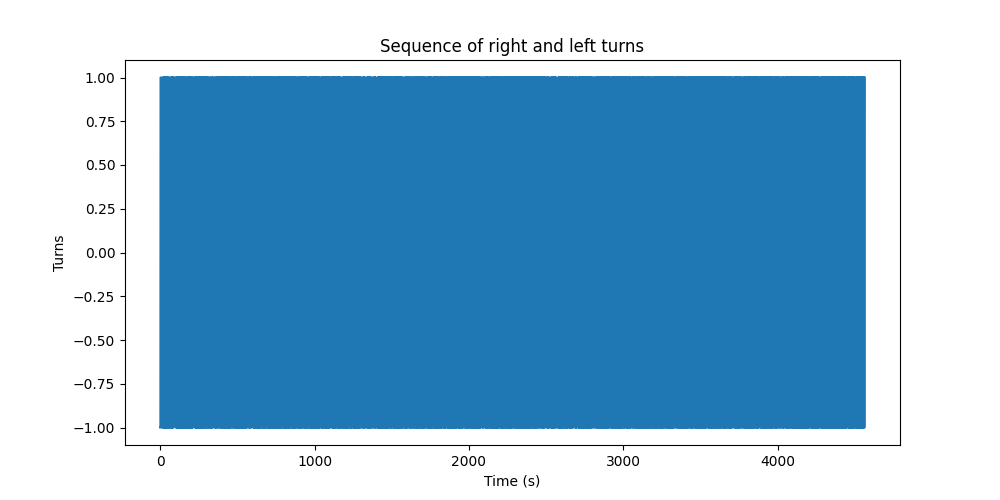

In [26]:
#  get sequence of right and left turns as 1 and -1
turns = np.sign(angles_at_peaks_diff)

#  plot the sequence of right and left turns

plt.figure(figsize=(10, 5)) 
plt.plot(turns)
plt.xlabel('Time (s)')
plt.ylabel('Turns')
plt.title('Sequence of right and left turns')
plt.show()


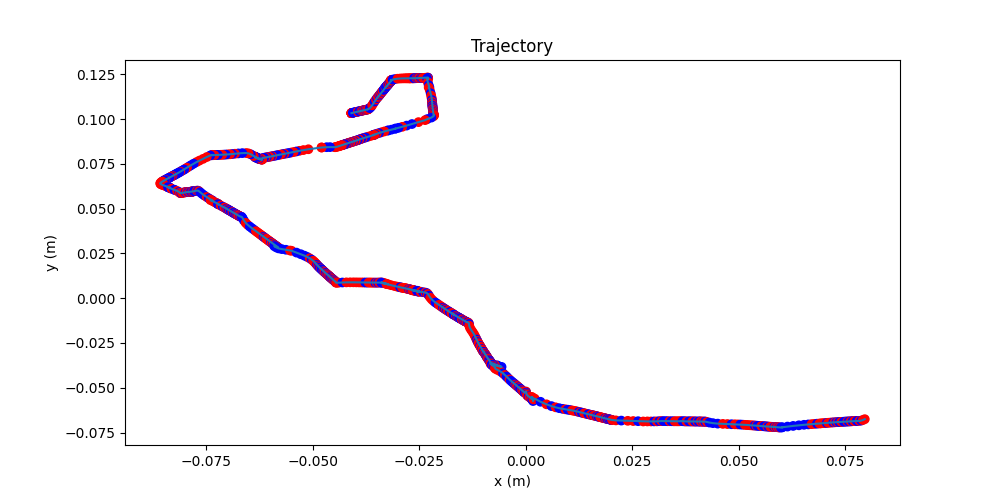

In [35]:
#  plot trajectory for 1000 frames with right and left turns as red and blue
plt.figure(figsize=(10, 5))
plt.plot(ddf.fishx[0:1000], ddf.fishy[0:1000])
plt.scatter(ddf.fishx[0:1000], ddf.fishy[0:1000], c=turns[0:1000], cmap='bwr')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Trajectory')
plt.show()


In [46]:
#  replace all -1 with 0 in turns
turns[turns == -1] = 0
print(turns)


[0. 0. 1. ... 0. 0. 1.]


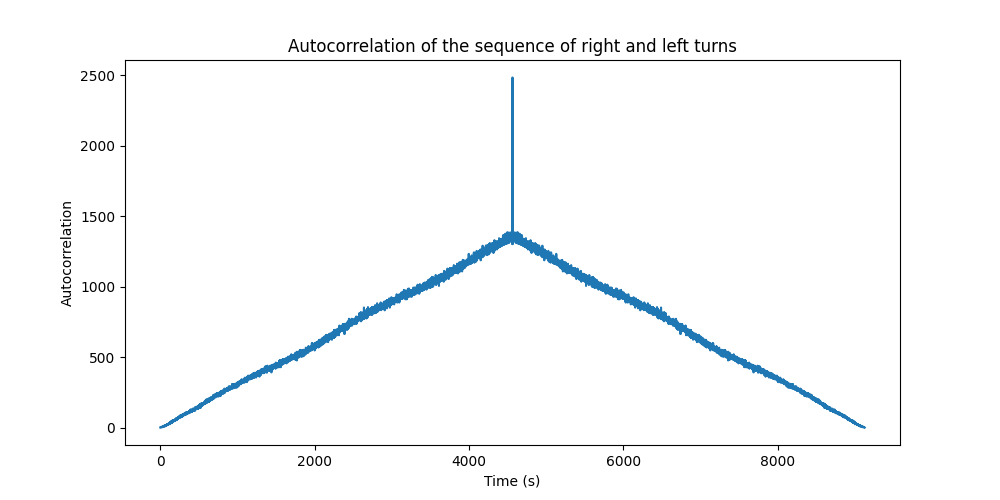

In [47]:
#  calculate autocorrelation of the sequence of right and left turns
autocorrelation = np.correlate(turns, turns, mode='full')

#  plot autocorrelation
plt.figure(figsize=(10, 5))
plt.plot(autocorrelation)
plt.xlabel('Time (s)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of the sequence of right and left turns')
plt.show()



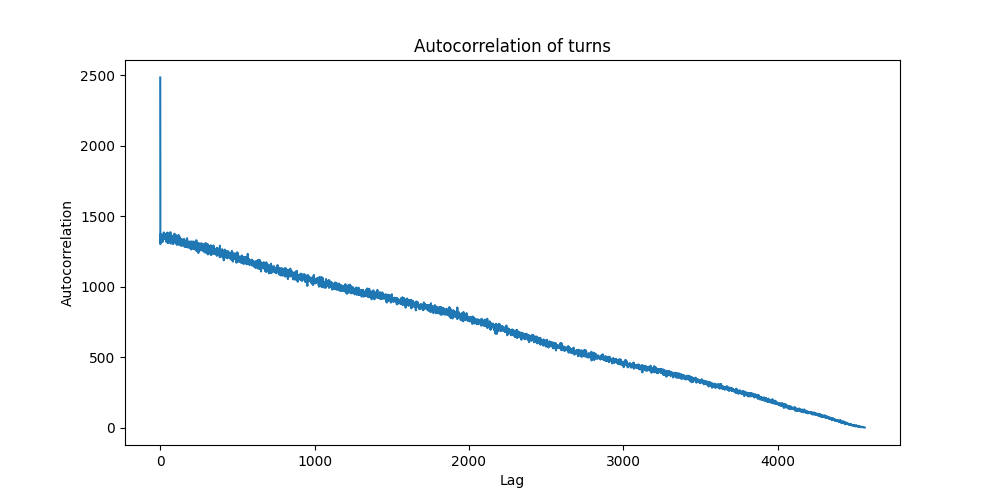

In [48]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

autocorr_vals = autocorr(turns)

plt.figure(figsize=(10, 5))
plt.plot(autocorr_vals)
plt.title('Autocorrelation of turns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


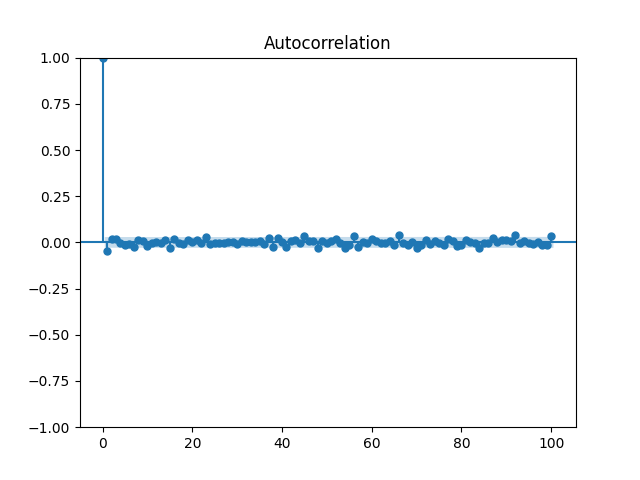

In [53]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(turns, lags=100)
plt.show()

In [54]:
def streak_lengths(turns):
    if len(turns) == 0:
        return np.array([])  # return empty array for empty input

    streaks = []
    current_streak = 1  # start with a streak of 1

    for i in range(1, len(turns)):
        if turns[i] == turns[i - 1]:  # if current turn is same as previous
            current_streak += 1  # increment streak count
        else:  # if current turn is different
            streaks.append(current_streak)  # add the streak to the list
            current_streak = 1  # reset streak count

    streaks.append(current_streak)  # add the last streak
    return np.array(streaks)

In [55]:
turns = np.array(turns)

In [56]:
streaks = streak_lengths(turns)

[2 7 7 ... 1 4 1]


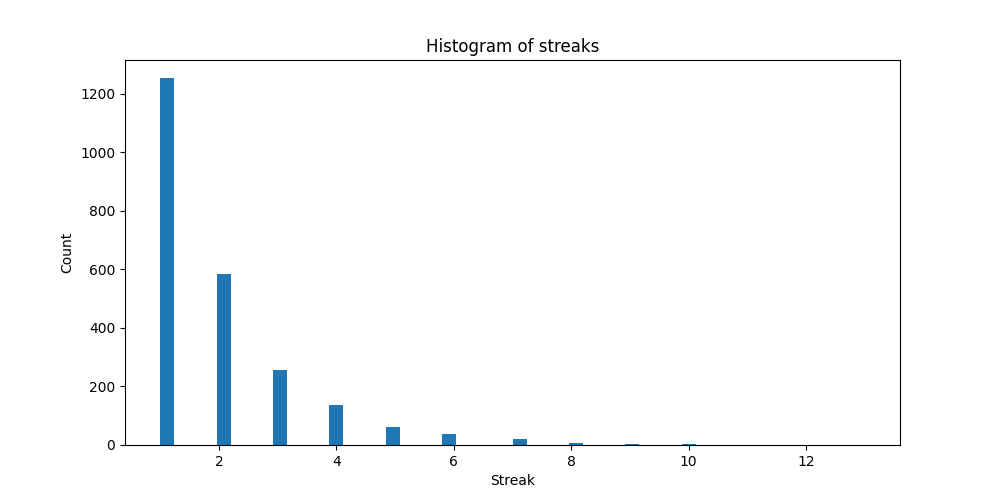

In [57]:
#  plot histogram of streaks
plt.figure(figsize=(10, 5))
plt.hist(streaks, bins=50)
plt.xlabel('Streak')
plt.ylabel('Count')
plt.title('Histogram of streaks')
plt.show()
